# No Scrubs Text Analysis
__Author:__ Sara Riker  
__Date:__ December 27, 2020

---


In [1]:
# install packages
%matplotlib inline

import pandas as pd
import numpy as np
from datetime import datetime
import emojis
import emoji
import regex
import re
import collections
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from wordcloud import WordCloud, STOPWORDS 

## Get Data

In [2]:
messages = pd.read_csv('messages_no_scrubs.csv')
messages.head()

,Chat Session,message_date,Deliver_date,read_date,service,type,sender_id,sender_name,status,subject,text,attachment,attachmen_type
0,No Scrubs,12/27/19 14:21,NaN,NaN,iMessage,Outgoing,NaN,NaN,Sent,NaN,NaN,IMG_2805.HEIC,Image
1,No Scrubs,12/27/19 14:21,NaN,NaN,iMessage,Outgoing,NaN,NaN,Sent,NaN,My dad is currently telling Milo about all the...,NaN,NaN
2,No Scrubs,12/27/19 14:22,NaN,12/27/19 14:22,iMessage,Incoming,1.917829e+10,Melissa Ross,Read,NaN,🤣🤣 also he got so big!!!,NaN,NaN
3,No Scrubs,12/27/19 14:22,NaN,NaN,iMessage,Outgoing,NaN,NaN,Sent,NaN,Liked “🤣🤣 also he got so big!!! ”,NaN,NaN
4,No Scrubs,12/27/19 14:23,NaN,12/27/19 14:23,iMessage,Incoming,1.610662e+10,Claire Soloman,Read,NaN,HAMBURGER,NaN,NaN


## Clean Data

In [3]:
# my messages don't have sender names
messages.sender_name = messages.sender_name.fillna('Sara Riker')

#Images show as null in text
messages['message'] = np.where(messages["text"].isnull(), messages["attachmen_type"], messages["text"] )

#tapbacks
tapbacks = ['Liked', 'Loved', 'Laughed', 'Emphasized', 'Disliked']
messages['tapback'] = np.where(messages['message'].str.split().str[0].isin(tapbacks), messages['message'].str.split().str[0], "")
messages['message'] = np.where(messages['message'].str.split().str[0].isin(tapbacks), messages['message'].str.split().str[0], messages['message'])
messages['date'] = messages['message_date'].str.split().str[0]
messages.date.apply(lambda x: datetime.strptime(x, '%m/%d/%y'))
messages['time'] = messages['message_date'].str.split().str[1]
messages.time.apply(lambda x: datetime.strptime(x, '%H:%M'))

# Emojis
#messages['emoji'] = messages_final['message'].apply(lambda x: emojis.get(x))

def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

messages["emoji"] = messages["message"].apply(split_count)

#URLs
URLPATTERN = r'(https?://\S+)'
messages['links'] = messages.message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

#only columns I care about 
messages_final = messages[['date', 'time', 'sender_name', 'message', 'tapback', 'emoji', 'links']]

#counts
messages_final['Letter_Count'] = messages_final['message'].apply(lambda s : len(s))
messages_final['Word_Count'] = messages_final['message'].apply(lambda s : len(s.split(' ')))

In [4]:
messages_final.head()

,date,time,sender_name,message,tapback,emoji,links,Letter_Count,Word_Count
0,12/27/19,14:21,Sara Riker,Image,,[],0,5,1
1,12/27/19,14:21,Sara Riker,My dad is currently telling Milo about all the...,,[😂],0,129,24
2,12/27/19,14:22,Melissa Ross,🤣🤣 also he got so big!!!,,"[🤣, 🤣]",0,25,7
3,12/27/19,14:22,Sara Riker,Liked,Liked,[],0,5,1
4,12/27/19,14:23,Claire Soloman,HAMBURGER,,[],0,9,1


## Summary Stats

In [17]:
total_messages = messages_final.shape[0]
emojis = sum(messages_final['emoji'].str.len())
links = np.sum(messages_final.links)

print("We sent", f"{total_messages:,d}", "total messages. There were", f"{emojis:,d}", "emojis and", links, "links sent.")

We sent 23,392 total messages. There were 1,650 emojis and 225 links sent.


In [6]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_final.sender_name.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_final[messages_final["sender_name"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]}:')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages:', f"{req_df.shape[0]:,d}")
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = round((np.sum(req_df['Word_Count']))/req_df.shape[0], 2)
  print('Words per message:', words_per_message)
  #media conists of media messages
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent:', emojis)
  #links consist of total links
  links = sum(req_df["links"])   
  print('Links Sent:', links)   
  print()

Stats of Sara Riker:
Messages: 5,866
Words per message: 7.55
Emojis Sent: 560
Links Sent: 110

Stats of Melissa Ross:
Messages: 2,738
Words per message: 8.38
Emojis Sent: 290
Links Sent: 2

Stats of Claire Soloman:
Messages: 9,794
Words per message: 8.1
Emojis Sent: 362
Links Sent: 93

Stats of Jess Thorn:
Messages: 4,994
Words per message: 11.24
Emojis Sent: 438
Links Sent: 20



# Tapbacks

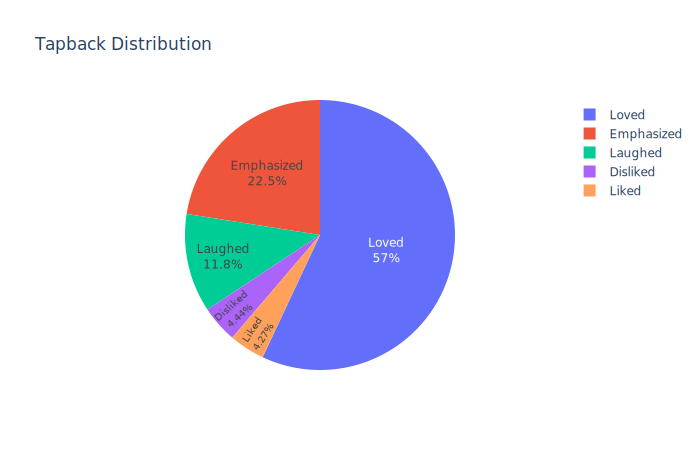

In [7]:
tb = messages_final[messages_final['tapback'] != ''].groupby('tapback')['message'].count().reset_index()
tb.columns = ['Tapback', 'Messages']
fig = px.pie(tb, values='Messages', names='Tapback',
             title='Tapback Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show(renderer="svg")

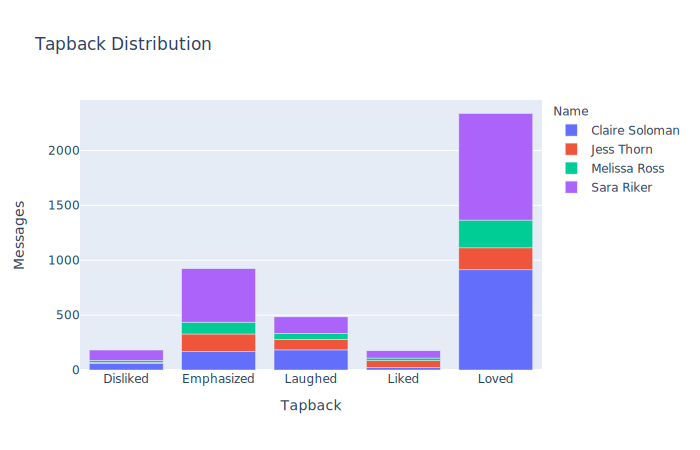

In [8]:
tb = messages_final[messages_final['tapback'] != ''].groupby(['sender_name', 'tapback'])['message'].count().reset_index()
tb.columns = ['Name','Tapback', 'Messages']

fig = px.bar(tb, y='Messages', x='Tapback', color = 'Name',
             title='Tapback Distribution')
fig.show(renderer="svg")

# Emojis

In [9]:
total_emojis_list = list([a for b in messages_final.emoji for a in b])
emoji_dict = dict(collections.Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,😂,282
1,❤️,247
2,🤣,184
3,🤷‍♀️,97
4,🤦🏼‍♀️,84
...,...,...
112,💙,1
113,🦃,1
114,🤗,1
115,🎁,1


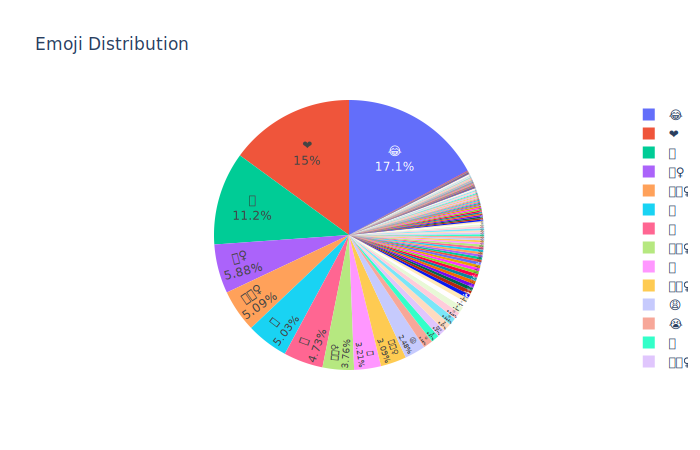

In [10]:
fig = px.pie(emoji_df, values='count', names='emoji',
             title='Emoji Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show(renderer="svg")

Emoji Distribution for Sara Riker


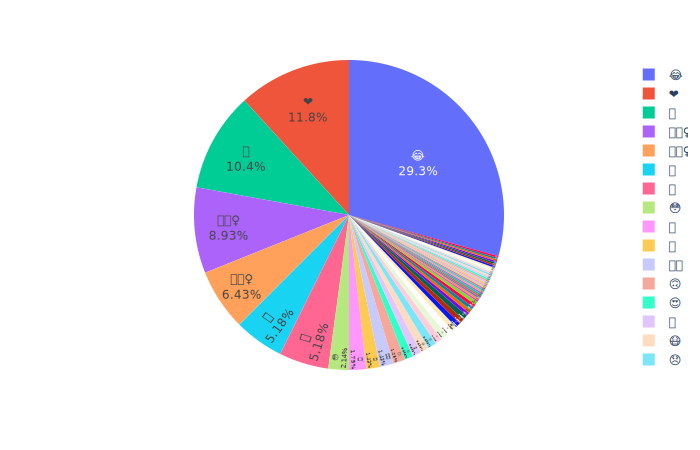

Emoji Distribution for Melissa Ross


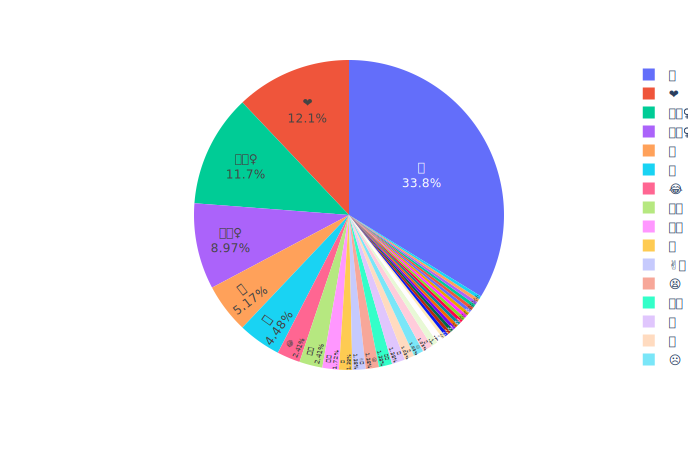

Emoji Distribution for Claire Soloman


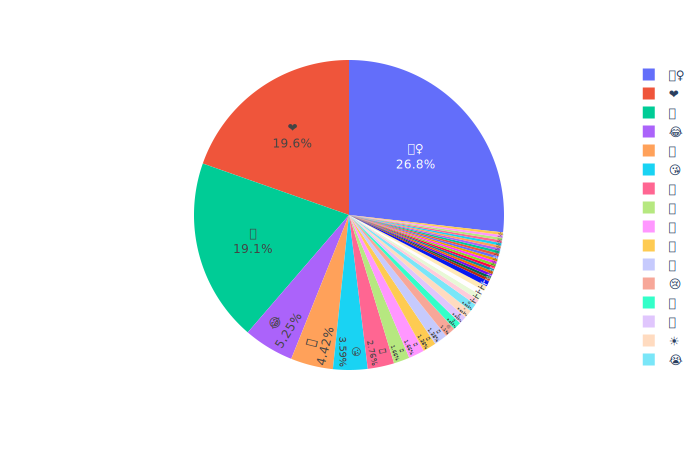

Emoji Distribution for Jess Thorn


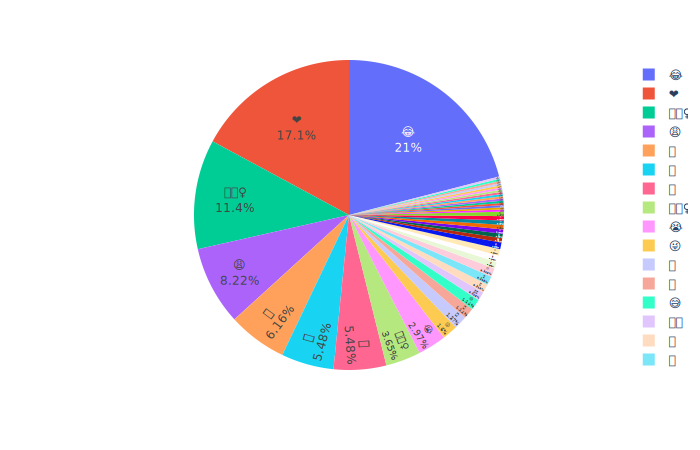

In [11]:
# Creates a list of unique Authors 
l = messages_final.sender_name.unique()
for i in range(len(l)):
  dummy_df = messages_final[messages_final['sender_name'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(collections.Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show(renderer="svg")

# Words

In [12]:
just_text = messages_final[messages_final['tapback'] == '']
just_text = just_text[just_text['message'] != 'Image']
just_text = just_text[just_text['links'] == 0]
text = " ".join(review for review in just_text.message)
print ("There are {} words in all the messages.".format(len(text)))

There are 970417 words in all the messages.


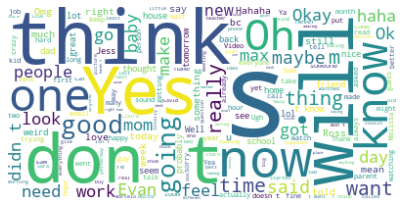

In [13]:
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:

plt.figure(figsize=(7,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Date and Time

In [14]:
messages_final['date'] = pd.to_datetime(messages_final['date'])
date_df = messages_final[['date', 'message']].groupby("date").count()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="date", y="message", title='Number of Messages as time moves on.')
fig.update_xaxes(nticks=20)
fig.show()

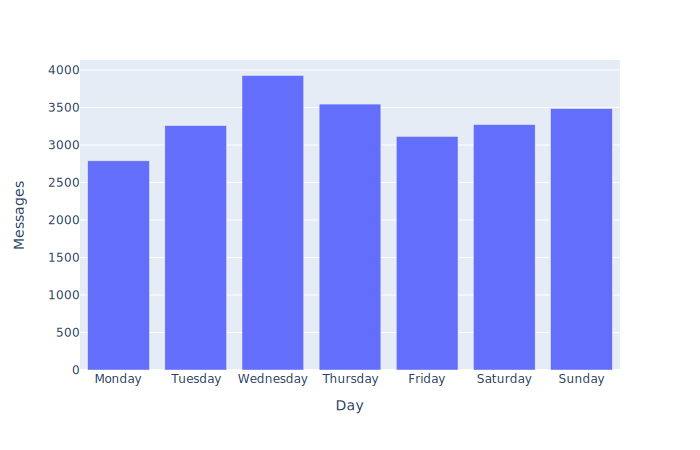

In [15]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
def dayofweek(i):
  d = days
  return d[i];
day_df=pd.DataFrame(messages_final["message"])
day_df['Day'] = messages_final['date'].dt.weekday
day_df['Day'] = day_df["Day"].apply(dayofweek)
day_df["Messages"] = 1
day = day_df.groupby("Day").sum()
day.reset_index(inplace=True)

day = day.set_index('Day').reindex(days).reset_index()
fig = px.bar(day, y='Messages', x='Day')
fig.show(renderer='svg')

Text(0, 0.5, 'time')

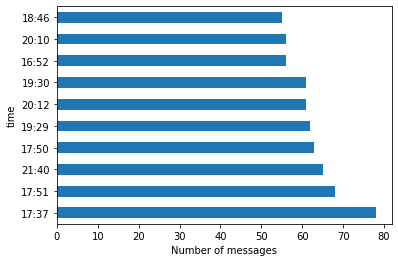

In [16]:
messages_final['time'].value_counts().head(10).plot.barh() 
plt.xlabel('Number of messages')
plt.ylabel('time')